In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm

PROJECT_ROOT = "/content/drive/MyDrive/datasets/face_counting"
TRAIN_DIR = os.path.join(PROJECT_ROOT, "train")
IMAGE_DIR = os.path.join(TRAIN_DIR, "image_data")

TRAIN_CSV = os.path.join(TRAIN_DIR, "train.csv")
TEST_CSV = os.path.join(PROJECT_ROOT, "test.csv")
BBOX_CSV = os.path.join(TRAIN_DIR, "bbox_train.csv")
LABELS_DIR = os.path.join(IMAGE_DIR, "labels")
os.makedirs(LABELS_DIR, exist_ok=True)


In [ ]:
# Load train.csv
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)
# Rename column in train_df if needed
if "Count" in train_df.columns and "HeadCount" not in train_df.columns:
    train_df.rename(columns={"Count": "HeadCount"}, inplace=True)
elif "HeadCount" not in train_df.columns:
    raise ValueError("train.csv must have a 'HeadCount' or 'Count' column.")

# Assume the training CSV has the filename in the first column,
# and test CSV has a column called "Name" with filenames.
train_filenames = set(train_df[train_df.columns[0]].astype(str))
test_filenames = set(test_df["Name"].astype(str))

# Combine filenames from both CSVs
valid_filenames = train_filenames.union(test_filenames)

# Clean up images not referenced in either train.csv or test.csv
for img_file in os.listdir(IMAGE_DIR):
    image_path = os.path.join(IMAGE_DIR, img_file)
    if os.path.isfile(image_path) and img_file not in valid_filenames:
        os.remove(image_path)
        print(f"Removed {img_file}")

print("Preprocessing complete. Remaining images in IMAGE_DIR:", len(os.listdir(IMAGE_DIR)))

Preprocessing complete. Remaining images in IMAGE_DIR: 8197


In [ ]:
# Load Haar cascade for face detection
haar_cascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
haar_cascade = cv2.CascadeClassifier(haar_cascade_path)

def detect_faces_haar(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = haar_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
    return len(faces), faces


In [ ]:
face_preds = []
image_files = [f for f in os.listdir(IMAGE_DIR)
               if (f.endswith(".jpg") or f.endswith(".png")) and f in train_filenames]

for fname in tqdm(image_files):
    img_path = os.path.join(IMAGE_DIR, fname)
    count, _ = detect_faces_haar(img_path)
    face_preds.append((fname, count))

df_haar = pd.DataFrame(face_preds, columns=["filename", "haar_count"])
df_haar.to_csv(os.path.join(TRAIN_DIR, "haar_preds.csv"), index=False)
print("Saved haar_preds.csv")


100%|██████████| 5733/5733 [08:26<00:00, 11.31it/s]

Saved haar_preds.csv


In [ ]:
# CSRNet Model & Training (Fixed with Training-Only Filtering)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import os
import cv2
from PIL import Image
from tqdm import tqdm

# CSRNet Model
class CSRNet(nn.Module):
    def __init__(self):
        super(CSRNet, self).__init__()
        base_vgg = models.vgg16_bn(weights=models.VGG16_BN_Weights.DEFAULT)
        self.frontend_features = nn.Sequential(*list(base_vgg.features[:30]))  # Extract first 30 layers
        self.backend_features = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, dilation=2, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, dilation=2, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, dilation=2, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, dilation=2, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, dilation=2, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 1, kernel_size=1),
        )

    def forward(self, x):
        x = self.frontend_features(x)
        x = self.backend_features(x)
        return x

# Generate Gaussian Heatmap
def create_gaussian_2d(width, height, cx, cy, sigma=4):
    xs = np.arange(0, width, 1, float)
    ys = np.arange(0, height, 1, float)[:, np.newaxis]
    return np.exp(-((xs - cx) ** 2 + (ys - cy) ** 2) / (2 * sigma * sigma))

# Dataset Class with Image Resizing & Error Handling
class CSRNetDataset(data.Dataset):
    def __init__(self, image_dir, bbox_df, transform=None, image_size=(512, 512)):
        self.image_dir = image_dir
        self.bbox_df = bbox_df
        self.groups = bbox_df.groupby("Name")
        self.names = list(self.groups.groups.keys())
        self.transform = transform
        self.image_size = image_size  # Ensure all images are the same size

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        name = self.names[idx]
        img_path = os.path.join(self.image_dir, name)  # Ensure correct filename format

        # Check if the image exists
        if not os.path.exists(img_path):
            print(f"Warning: Image file not found, skipping {img_path}")
            return None

        img = Image.open(img_path).convert("RGB")
        # Resize image for consistency
        img = img.resize(self.image_size, Image.BILINEAR)
        np_img = np.array(img)
        h, w, _ = np_img.shape

        # Create Density Map
        blank_map = np.zeros((h, w), dtype=np.float32)
        if name in self.groups.groups:
            group = self.groups.get_group(name)
            for _, row in group.iterrows():
                x_center = (row["xmin"] + row["xmax"]) / 2.0
                y_center = (row["ymin"] + row["ymax"]) / 2.0
                gauss = create_gaussian_2d(w, h, x_center, y_center, sigma=4)
                blank_map += gauss.astype(np.float32)

        # Downsample Density Map
        factor = 8
        ds_w = self.image_size[0] // factor
        ds_h = self.image_size[1] // factor
        ds_map = cv2.resize(blank_map, (ds_w, ds_h), interpolation=cv2.INTER_CUBIC)
        ds_map *= (factor * factor)

        if self.transform:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)

        density_map = torch.from_numpy(ds_map).unsqueeze(0)  # shape (1, ds_h, ds_w)
        return img, density_map

# CSRNet Training Function
def train_csrnet(bbox_df, image_dir, epochs=3, batch_size=2, lr=1e-4):
    dataset = CSRNetDataset(image_dir, bbox_df, transform=transforms.ToTensor())

    # Filter out None values to avoid issues with missing images
    valid_samples = [s for s in dataset if s is not None]

    if len(valid_samples) == 0:
        raise ValueError("No valid images found. Check dataset paths.")

    dataloader = data.DataLoader(valid_samples, batch_size=batch_size, shuffle=True)

    model = CSRNet()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    model.train()
    for ep in range(epochs):
        running_loss = 0.0
        for imgs, dmaps in dataloader:
            imgs = imgs.to(device)
            dmaps = dmaps.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, dmaps)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"CSRNet Epoch [{ep+1}/{epochs}] - Loss: {running_loss/len(dataloader):.4f}")

    save_path = os.path.join(TRAIN_DIR, "csrnet_best.pth")
    torch.save({"state_dict": model.state_dict()}, save_path)
    print(f"CSRNet trained. Checkpoint saved at {save_path}")


# Load CSV files and define paths
bbox_train_df = pd.read_csv(os.path.join(TRAIN_DIR, "bbox_train.csv"))
train_df = pd.read_csv(TRAIN_CSV)

print("BBox Train Columns:", bbox_train_df.columns)
print("Train CSV Columns:", train_df.columns)

# Use the preprocessed IMAGE_DIR that now contains only images from the union of train and test.
# Filter for training images only using train_filenames from your preprocessing cell.
train_filenames = set(train_df[train_df.columns[0]].astype(str))

# Get list of images currently in IMAGE_DIR that belong to training set
available_train_images = {f for f in os.listdir(IMAGE_DIR) if f.endswith(".jpg") and f in train_filenames}
print(f"First 10 training images in directory: {list(available_train_images)[:10]}")
print(f"Total training images found in directory: {len(available_train_images)}")

# Filter bbox_train_df to only include images that exist in IMAGE_DIR (and are in train_filenames)
bbox_train_df["Name"] = bbox_train_df["Name"].astype(str)
bbox_train_df = bbox_train_df[bbox_train_df["Name"].isin(available_train_images)]

if len(bbox_train_df) == 0:
    raise ValueError("No matching training images found. Check if names in bbox_train_df match filenames in IMAGE_DIR.")

# Train CSRNet if enabled
DO_TRAIN_CSR = True
if DO_TRAIN_CSR:
    train_csrnet(bbox_train_df, IMAGE_DIR, epochs=3, batch_size=2, lr=1e-4)
else:
    print("Skipping CSRNet training.")


BBox Train Columns: Index(['Name', 'width', 'height', 'xmin', 'ymin', 'xmax', 'ymax'], dtype='object')
Train CSV Columns: Index(['Name', 'HeadCount'], dtype='object')
First 10 training images in directory: ['16602.jpg', '10943.jpg', '10989.jpg', '12452.jpg', '17031.jpg', '17284.jpg', '11278.jpg', '12664.jpg', '12382.jpg', '16263.jpg']
Total training images found in directory: 5733


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:02<00:00, 229MB/s]


CSRNet Epoch [1/3] - Loss: 2.9817
CSRNet Epoch [2/3] - Loss: 2.7582
CSRNet Epoch [3/3] - Loss: 2.6345
CSRNet trained. Checkpoint saved at /content/drive/MyDrive/datasets/face_counting/train/csrnet_best.pth


In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import os
from tqdm import tqdm

# Load the trained CSRNet model checkpoint
csrnet_checkpoint = os.path.join(TRAIN_DIR, "csrnet_best.pth")
csrnet_model = CSRNet()  # Ensure CSRNet is defined as in your training cell
checkpoint = torch.load(csrnet_checkpoint, map_location=torch.device("cpu"))
csrnet_model.load_state_dict(checkpoint["state_dict"])
csrnet_model.eval()

# Define transform (ensure it matches what was used during training)
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

# Use train.csv to filter training images
TRAIN_CSV = os.path.join(TRAIN_DIR, "train.csv")
train_df = pd.read_csv(TRAIN_CSV)
train_filenames = set(train_df["Name"].astype(str))

# Process only training images in IMAGE_DIR
image_files = [f for f in os.listdir(IMAGE_DIR) if f.endswith(".jpg") and f in train_filenames]
print(f"Processing {len(image_files)} training images for CSRNet inference.")

predictions = []
for fname in tqdm(image_files, desc="CSRNet Training Inference"):
    img_path = os.path.join(IMAGE_DIR, fname)
    try:
        image = Image.open(img_path).convert("RGB")
    except Exception as e:
        print(f"Error opening {img_path}: {e}")
        continue
    image = image.resize((512, 512), Image.BILINEAR)
    input_tensor = transform(image).unsqueeze(0)  # add batch dimension
    with torch.no_grad():
        density_map = csrnet_model(input_tensor)
        # Sum the density map to get the predicted count.
        count = density_map.sum().item()
    predictions.append((fname, count))

df_csr_train = pd.DataFrame(predictions, columns=["filename", "csr_count"])
df_csr_train.to_csv(os.path.join(TRAIN_DIR, "csrnet_preds.csv"), index=False)
print("CSRNet training predictions saved.")


Processing 5733 training images for CSRNet inference.


CSRNet Training Inference: 100%|██████████| 5733/5733 [1:16:09<00:00,  1.25it/s]

CSRNet training predictions saved.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
import torch.utils.data as data
from PIL import Image
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Define image directory
IMAGE_DIR = "/content/drive/MyDrive/datasets/face_counting/train/image_data"

# Load train.csv (which only contains training images)
TRAIN_CSV = os.path.join("/content/drive/MyDrive/datasets/face_counting/train", "train.csv")
train_df = pd.read_csv(TRAIN_CSV)

# Filter train_df to ensure that each image exists in IMAGE_DIR.
# First, get the set of filenames from train.csv.
train_filenames = set(train_df["Name"].astype(str))

# Then, list only the images in IMAGE_DIR that are both .jpg and in the training set.
valid_train_images = [img for img in os.listdir(IMAGE_DIR) if img.endswith(".jpg") and img in train_filenames]

# Filter train_df accordingly.
train_df = train_df[train_df["Name"].isin(valid_train_images)]
print(f"Total images in IMAGE_DIR: {len(os.listdir(IMAGE_DIR))}")
print(f"Remaining training images after filtering: {len(train_df)}")

# ✅ Fix 1: Use correct weight loading (pretrained=True is deprecated)
from torchvision.models import ResNet18_Weights

class RegressionCNN(nn.Module):
    def __init__(self):
        super(RegressionCNN, self).__init__()
        self.model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.model.fc = nn.Linear(self.model.fc.in_features, 1)

    def forward(self, x):
        return self.model(x).view(-1)  # ✅ Fix 2: Ensure output shape

# Define dataset class
class ImageDataset(data.Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, img_name)

        if not os.path.exists(img_path):  # ✅ Fix 3: Handle missing images
            print(f"Warning: Image not found {img_path}")
            return None

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        label = torch.tensor(float(self.df.iloc[idx, 1]), dtype=torch.float32)
        return image, label

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Train/Test split
train_data, test_data = train_test_split(train_df, test_size=0.2, random_state=42)

train_dataset = ImageDataset(train_data, IMAGE_DIR, transform=transform)
test_dataset = ImageDataset(test_data, IMAGE_DIR, transform=transform)

train_loader = data.DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=2, shuffle=False)

# Define training function for RegressionCNN
def train_regcnn(epochs=3, batch_size=2, lr=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = RegressionCNN().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for ep in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in dataloader:
            if inputs is None:  # Skip missing images
                continue
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs).view(-1)  # Ensure correct tensor shape
            loss = criterion(outputs, targets.view(-1))  # Ensure correct loss shape
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"RegressionCNN Epoch [{ep+1}/{epochs}] - Loss: {running_loss/len(dataloader):.4f}")

    # ✅ Fix 5: Save model correctly
    save_path = os.path.join("/content/drive/MyDrive/datasets/face_counting/train", "regcnn_best.pth")
    torch.save({"state_dict": model.state_dict()}, save_path)
    print(f"RegressionCNN trained. Checkpoint saved at {save_path}")

# Run training
DO_TRAIN_REG = True
if DO_TRAIN_REG:
    train_regcnn(epochs=3, batch_size=2, lr=1e-4)
else:
    print("Skipping Regression CNN training.")

Total images in IMAGE_DIR: 8197
Remaining training images after filtering: 5733


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 200MB/s]


RegressionCNN Epoch [1/3] - Loss: 4.6816
RegressionCNN Epoch [2/3] - Loss: 2.9469
RegressionCNN Epoch [3/3] - Loss: 2.1569
RegressionCNN trained. Checkpoint saved at /content/drive/MyDrive/datasets/face_counting/train/regcnn_best.pth


In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import os
from tqdm import tqdm

# Load the trained RegressionCNN model checkpoint
regcnn_checkpoint = os.path.join(TRAIN_DIR, "regcnn_best.pth")
regcnn_model = RegressionCNN()  # Ensure RegressionCNN is defined as in your training cell
checkpoint = torch.load(regcnn_checkpoint, map_location=torch.device("cpu"))
regcnn_model.load_state_dict(checkpoint["state_dict"])
regcnn_model.eval()

# Define the transform matching the training preprocessing for RegressionCNN.
# (Ensure this matches what you used during training.)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the size used during training
    transforms.ToTensor()
])

# Use train.csv to filter training images
TRAIN_CSV = os.path.join(TRAIN_DIR, "train.csv")
train_df = pd.read_csv(TRAIN_CSV)
train_filenames = set(train_df["Name"].astype(str))

# Process only training images in IMAGE_DIR
image_files = [f for f in os.listdir(IMAGE_DIR) if f.endswith(".jpg") and f in train_filenames]
print(f"Processing {len(image_files)} training images for RegressionCNN inference.")

predictions = []
for fname in tqdm(image_files, desc="RegCNN Training Inference"):
    img_path = os.path.join(IMAGE_DIR, fname)
    try:
        image = Image.open(img_path).convert("RGB")
    except Exception as e:
        print(f"Error opening {img_path}: {e}")
        continue
    # Apply the transform and add a batch dimension
    image = transform(image).unsqueeze(0)
    with torch.no_grad():
        # Get the predicted count from the model
        count = regcnn_model(image).item()
    predictions.append((fname, count))

# Save predictions to CSV
df_reg_train = pd.DataFrame(predictions, columns=["filename", "regression_count"])
output_path = os.path.join(TRAIN_DIR, "regcnn_preds.csv")
df_reg_train.to_csv(output_path, index=False)
print(f"RegressionCNN training predictions saved to {output_path}")


Processing 5733 training images for RegressionCNN inference.


RegCNN Training Inference: 100%|██████████| 5733/5733 [04:24<00:00, 21.67it/s]


RegressionCNN training predictions saved to /content/drive/MyDrive/datasets/face_counting/train/regcnn_preds.csv


In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import os
from tqdm import tqdm

# Load the saved CSRNet model checkpoint
csrnet_checkpoint = os.path.join(TRAIN_DIR, "csrnet_best.pth")
csrnet_model = CSRNet()  # Assuming CSRNet is defined (as in your training cell)
checkpoint = torch.load(csrnet_checkpoint, map_location=torch.device("cpu"))
csrnet_model.load_state_dict(checkpoint["state_dict"])
csrnet_model.eval()

# Define the transform to match the training preprocessing for CSRNet.
# (Make sure the size here matches what was used during training.)
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Use the same size as in training (if different, update here)
    transforms.ToTensor()
])

# For test inference, load test.csv and filter IMAGE_DIR accordingly.
TEST_CSV = os.path.join(PROJECT_ROOT, "test.csv")
test_df = pd.read_csv(TEST_CSV)  # Expecting a column "Name" with filenames
test_filenames = set(test_df["Name"].astype(str))

# Filter IMAGE_DIR to process only test images.
image_files = [f for f in os.listdir(IMAGE_DIR) if f.endswith(".jpg") and f in test_filenames]
print(f"Processing {len(image_files)} test images for CSRNet inference.")

predictions = []
for fname in tqdm(image_files, desc="CSRNet Test Inference"):
    img_path = os.path.join(IMAGE_DIR, fname)
    try:
        image = Image.open(img_path).convert("RGB")
    except Exception as e:
        print(f"Error opening {img_path}: {e}")
        continue
    image = image.resize((512, 512), Image.BILINEAR)
    input_tensor = transform(image).unsqueeze(0)  # add batch dimension
    with torch.no_grad():
        density_map = csrnet_model(input_tensor)
        # Sum the density map to get the predicted count.
        count = density_map.sum().item()
    predictions.append((fname, count))

df_csr_inference = pd.DataFrame(predictions, columns=["filename", "csr_count"])
df_csr_inference.to_csv(os.path.join(TRAIN_DIR, "csrnet_test_preds.csv"), index=False)
print("CSRNet test inference predictions saved.")


Processing 2463 test images for CSRNet inference.


CSRNet Test Inference: 100%|██████████| 2463/2463 [33:05<00:00,  1.24it/s]

CSRNet test inference predictions saved.


In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
import os
from tqdm import tqdm

# Load the saved RegressionCNN model checkpoint
regcnn_checkpoint = os.path.join(TRAIN_DIR, "regcnn_best.pth")
regcnn_model = RegressionCNN()  # Assuming RegressionCNN is defined (as in your training cell)
checkpoint_reg = torch.load(regcnn_checkpoint, map_location=torch.device("cpu"))
regcnn_model.load_state_dict(checkpoint_reg["state_dict"])
regcnn_model.eval()

# Define the transform to match the training preprocessing for RegressionCNN.
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Use the same size as used during training
    transforms.ToTensor()
])

# For test inference, load test.csv and filter IMAGE_DIR accordingly.
TEST_CSV = os.path.join(PROJECT_ROOT, "test.csv")
test_df = pd.read_csv(TEST_CSV)  # Expecting a column "Name" with filenames
test_filenames = set(test_df["Name"].astype(str))

# Filter IMAGE_DIR to process only test images.
image_files = [f for f in os.listdir(IMAGE_DIR) if f.endswith(".jpg") and f in test_filenames]
print(f"Processing {len(image_files)} test images for RegressionCNN inference.")

predictions = []
for fname in tqdm(image_files, desc="RegCNN Test Inference"):
    img_path = os.path.join(IMAGE_DIR, fname)
    try:
        image = Image.open(img_path).convert("RGB")
    except Exception as e:
        print(f"Error opening {img_path}: {e}")
        continue
    image = transform(image).unsqueeze(0)  # add batch dimension
    with torch.no_grad():
        count = regcnn_model(image).item()
    predictions.append((fname, count))

df_reg_inference = pd.DataFrame(predictions, columns=["filename", "regression_count"])
df_reg_inference.to_csv(os.path.join(TRAIN_DIR, "regcnn_test_preds.csv"), index=False)
print("RegressionCNN test inference predictions saved.")


Processing 2463 test images for RegressionCNN inference.


RegCNN Test Inference: 100%|██████████| 2463/2463 [02:23<00:00, 17.22it/s]

RegressionCNN test inference predictions saved.


In [ ]:
import os
import cv2
import pandas as pd
from tqdm import tqdm

# Define paths
TEST_CSV = os.path.join(PROJECT_ROOT, "test.csv")
test_df = pd.read_csv(TEST_CSV)  # Expecting a column "Name" with filenames

print("IMAGE_DIR:", IMAGE_DIR)
print("File count in IMAGE_DIR:", len(os.listdir(IMAGE_DIR)))

haar_test_preds = []
for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Haar Test Inference"):
    fname = row["Name"]
    img_path = os.path.join(IMAGE_DIR, fname)
    # Check if the image exists
    if not os.path.isfile(img_path):
        print(f"Missing file: {img_path}")
        continue
    count, _ = detect_faces_haar(img_path)
    haar_test_preds.append((fname, count))

df_haar_test = pd.DataFrame(haar_test_preds, columns=["filename", "haar_count"])
df_haar_test.to_csv(os.path.join(TRAIN_DIR, "haar_test_preds.csv"), index=False)
print("Haar test predictions saved.")

IMAGE_DIR: /content/drive/MyDrive/datasets/face_counting/train/image_data
File count in IMAGE_DIR: 8197


Haar Test Inference: 100%|██████████| 2463/2463 [03:08<00:00, 13.05it/s]

Haar test predictions saved.


In [ ]:
# Ensemble (Haar + CSRNet + RegCNN with XGBoost)

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Load predictions
df_haar = pd.read_csv(os.path.join(TRAIN_DIR, "haar_preds.csv"))
df_csr = pd.read_csv(os.path.join(TRAIN_DIR, "csrnet_preds.csv"))
df_reg = pd.read_csv(os.path.join(TRAIN_DIR, "regcnn_preds.csv"))

# Merge with ground truth from train.csv
ensemble_df = (
    train_df.merge(
        df_haar.rename(columns={"filename": "Name", "haar_count": "Haar_Pred"}),
        on="Name", how="left"
    )
    .merge(
        df_csr.rename(columns={"filename": "Name", "csr_count": "CSRNet_Pred"}),
        on="Name", how="left"
    )
    .merge(
        df_reg.rename(columns={"filename": "Name", "regression_count": "RegCNN_Pred"}),
        on="Name", how="left"
    )
)

ensemble_df.fillna(0, inplace=True)
X = ensemble_df[["Haar_Pred", "CSRNet_Pred", "RegCNN_Pred"]]
y = ensemble_df["HeadCount"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
ensemble_model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)
ensemble_model.fit(X_train, y_train)

y_pred = ensemble_model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Ensemble Validation RMSE: {val_rmse:.3f}")

# Save the ensemble model
ensemble_model.save_model(os.path.join(TRAIN_DIR, "ensemble_model.json"))
print("Ensemble model saved.")

Ensemble Validation RMSE: 2.271
Ensemble model saved.


In [ ]:
# Final Test Predictions with Haar, CSRNet, and RegCNN

TEST_CSV = os.path.join(PROJECT_ROOT, "test.csv")
if os.path.isfile(TEST_CSV):
    test_df = pd.read_csv(TEST_CSV)
    # The following files must exist from the test inference steps:
    test_haar_preds = os.path.join(TRAIN_DIR, "haar_test_preds.csv")
    test_csr_preds = os.path.join(TRAIN_DIR, "csrnet_test_preds.csv")
    test_reg_preds = os.path.join(TRAIN_DIR, "regcnn_test_preds.csv")

    if all(os.path.isfile(x) for x in [test_haar_preds, test_csr_preds, test_reg_preds]):
        df_th = pd.read_csv(test_haar_preds).rename(columns={"filename": "Name", "haar_count": "Haar_Pred"})
        df_tc = pd.read_csv(test_csr_preds).rename(columns={"filename": "Name", "csr_count": "CSRNet_Pred"})
        df_tr = pd.read_csv(test_reg_preds).rename(columns={"filename": "Name", "regression_count": "RegCNN_Pred"})

        test_ensemble = (
            test_df.merge(df_th, on="Name", how="left")
                   .merge(df_tc, on="Name", how="left")
                   .merge(df_tr, on="Name", how="left")
        )
        test_ensemble.fillna(0, inplace=True)
        X_test = test_ensemble[["Haar_Pred", "CSRNet_Pred", "RegCNN_Pred"]]

        from xgboost import XGBRegressor
        final_model = XGBRegressor()
        final_model.load_model(os.path.join(TRAIN_DIR, "ensemble_model.json"))
        test_ensemble["HeadCount"] = final_model.predict(X_test)

        out_path = os.path.join(PROJECT_ROOT, "final_submission.csv")
        test_ensemble[["Name", "HeadCount"]].to_csv(out_path, index=False)
        print(f"Final predictions saved to {out_path}")
    else:
        print("No Haar/CSRNet/RegCNN test predictions for test images. Skipping.")
else:
    print("No test.csv found. Skipping final test predictions.")


Final predictions saved to /content/drive/MyDrive/datasets/face_counting/final_submission.csv


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Merge Haar, CSRNet, and Regression predictions
df_haar = pd.read_csv(os.path.join(TRAIN_DIR, "haar_preds.csv"))
df_csr = pd.read_csv(os.path.join(TRAIN_DIR, "csrnet_preds.csv"))
df_reg = pd.read_csv(os.path.join(TRAIN_DIR, "regcnn_preds.csv"))

# Merge into a single DataFrame
df_ensemble = df_haar.merge(df_csr, on="filename").merge(df_reg, on="filename")

# Add ground truth headcounts
df_truth = train_df[["Name", "HeadCount"]].rename(columns={"Name": "filename"})
df_ensemble = df_ensemble.merge(df_truth, on="filename")

# Define features and target
X = df_ensemble[["haar_count", "csr_count", "regression_count"]]
y = df_ensemble["HeadCount"]

# Hyperparameter search space
param_dist = {
    "n_estimators": [50, 100, 200],
    "max_depth": [2, 3, 4, 5],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}

# Initialize model and RandomizedSearchCV
xgb_model = XGBRegressor(objective="reg:squarederror", random_state=42)
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring="neg_root_mean_squared_error",
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Train ensemble model
random_search.fit(X, y)
best_model = random_search.best_estimator_
print("Best XGBoost Parameters:", random_search.best_params_)

# Predict and save ensemble output
df_ensemble["count"] = best_model.predict(X).round().astype(int)
df_ensemble[["filename", "count"]].to_csv(os.path.join(TRAIN_DIR, "ensemble_preds.csv"), index=False)
print("Final ensemble predictions saved using optimized XGBoost.")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best XGBoost Parameters: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 2, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Final ensemble predictions saved using optimized XGBoost.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


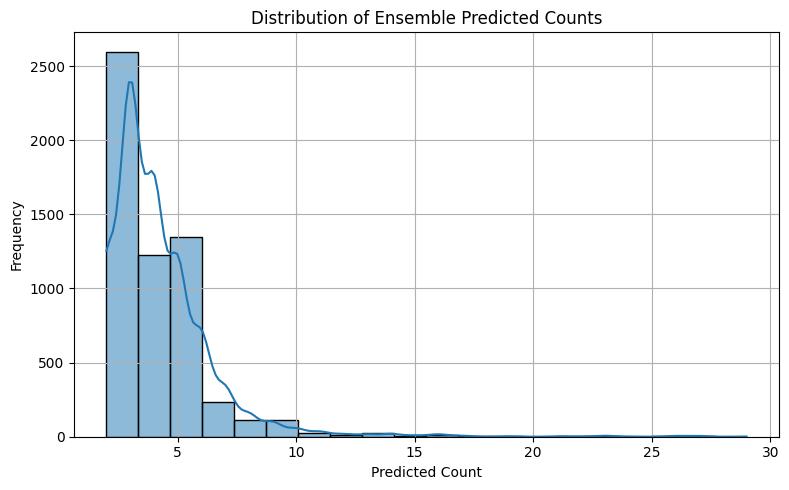

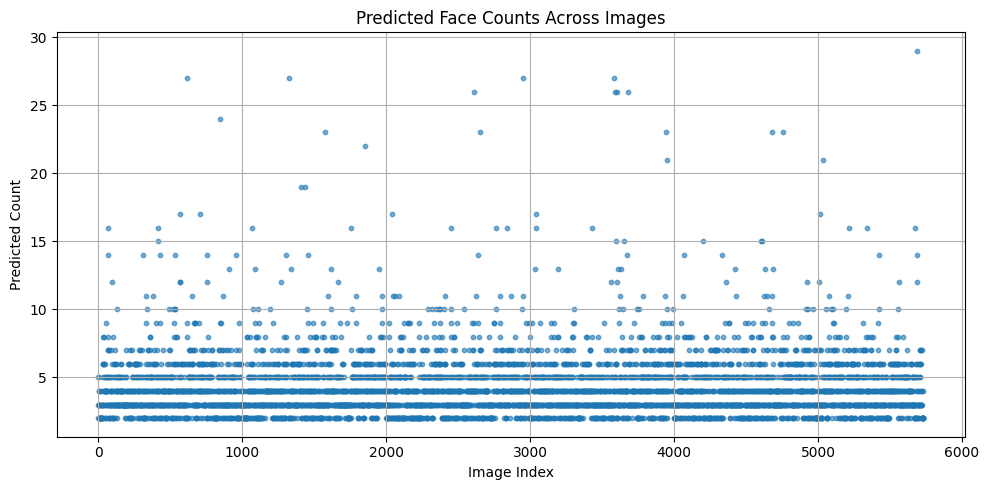

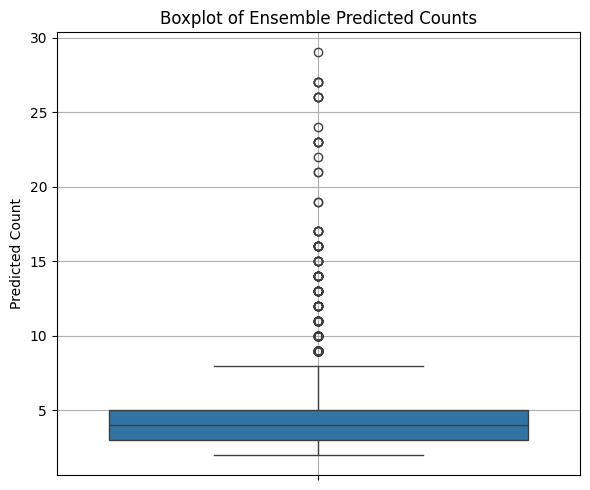

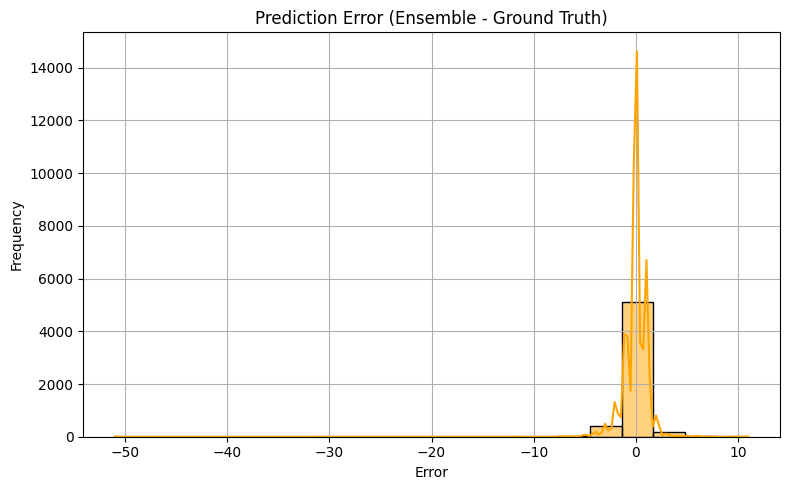

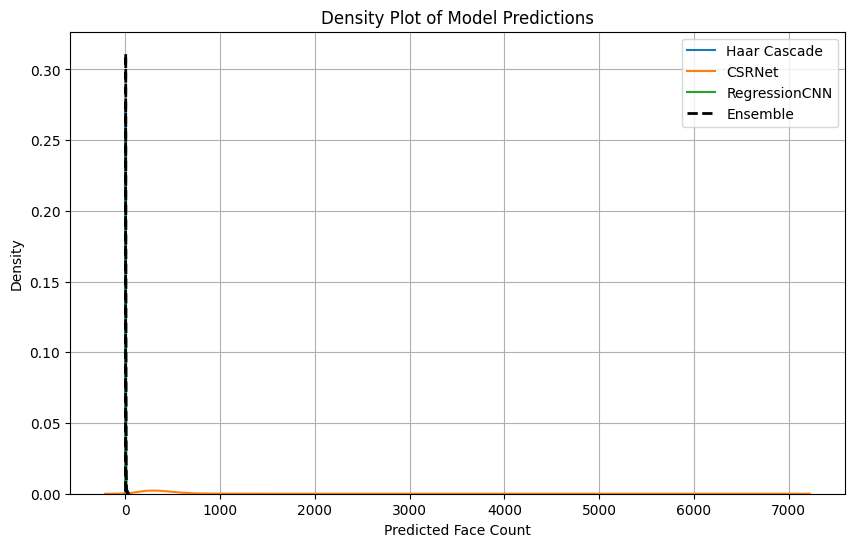

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# File paths
ensemble_path = "/content/drive/MyDrive/datasets/face_counting/train/ensemble_preds.csv"
train_csv_path = "/content/drive/MyDrive/datasets/face_counting/train/train.csv"

# Load data
ensemble_df = pd.read_csv(ensemble_path)
train_df = pd.read_csv(train_csv_path)

# 1. Distribution of Ensemble Predicted Counts
plt.figure(figsize=(8, 5))
sns.histplot(ensemble_df["count"], bins=20, kde=True)
plt.title("Distribution of Ensemble Predicted Counts")
plt.xlabel("Predicted Count")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Predicted Count per Image (Index Plot)
plt.figure(figsize=(10, 5))
plt.scatter(range(len(ensemble_df)), ensemble_df["count"], alpha=0.6, s=10)
plt.title("Predicted Face Counts Across Images")
plt.xlabel("Image Index")
plt.ylabel("Predicted Count")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Boxplot of Prediction Distribution
plt.figure(figsize=(6, 5))
sns.boxplot(y=ensemble_df["count"])
plt.title("Boxplot of Ensemble Predicted Counts")
plt.ylabel("Predicted Count")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Error Distribution (if HeadCount available)
if "HeadCount" in train_df.columns:
    merged = ensemble_df.merge(train_df[["Name", "HeadCount"]], left_on="filename", right_on="Name")
    merged["error"] = merged["count"] - merged["HeadCount"]

    plt.figure(figsize=(8, 5))
    sns.histplot(merged["error"], bins=20, kde=True, color="orange")
    plt.title("Prediction Error (Ensemble - Ground Truth)")
    plt.xlabel("Error")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Ground truth column 'HeadCount' not found in train_df.")

import seaborn as sns

plt.figure(figsize=(10, 6))
sns.kdeplot(df_ensemble["haar_count"], label="Haar Cascade", bw_adjust=1.2)
sns.kdeplot(df_ensemble["csr_count"], label="CSRNet", bw_adjust=1.2)
sns.kdeplot(df_ensemble["regression_count"], label="RegressionCNN", bw_adjust=1.2)
sns.kdeplot(df_ensemble["count"], label="Ensemble", color='black', linewidth=2, linestyle="--")
plt.title("Density Plot of Model Predictions")
plt.xlabel("Predicted Face Count")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

